In [64]:
import sys
sys.path.append('../')
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from panav.env import NavigationEnv, Box2DRegion, PolygonRegion, box_2d_center, line_seg_to_obstacle
from panav.viz import draw_env
%load_ext autoreload
%autoreload 2

## ORCA: a distributed local collision avoidance protocol

ORCA paper source: https://gamma.cs.unc.edu/ORCA/publications/ORCA.pdf

ORCA runs on every individual agent.

Input(for the ORCA algorithm on each agent):
* The locations and 'optimization velocities' $v_{opt}$ of neighboring agents.
* The location and 'optimization velocity' of the agent itself.
* The 'preferred velcoity' $v_{pref}$ of the agent itself.
* Desired safe time interval projected forward $\tau$.
* bloating radius of the agents.
* Static obstacles.

Output:
* A safe velocity $v$ to be traveled at for the next $\tau$ seconds.

# Step 1: avoiding a static obstacle(polygon)

In simulation, would need to compute which face of the polygon is closest to the agent, and compute the corresponding velocity obstacle thereof.

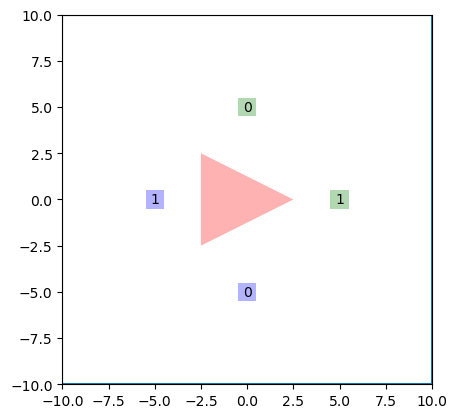

In [ ]:

start_locs = np.array([[0,-5],[-5,0]])
goal_locs = np.array([[0,5],[5,0]])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]


limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 

O1 = PolygonRegion([(-2.5,2.5),(-2.5,-2.5),(2.5,0)])


env = NavigationEnv(limits,[O1],starts,goals)

draw_env(env)

In [74]:
bloating_r = 0.5
tau = 0.1

d = 2
K = 10
t0 = 0
vmax = 1.0
interp_dt = 0.1

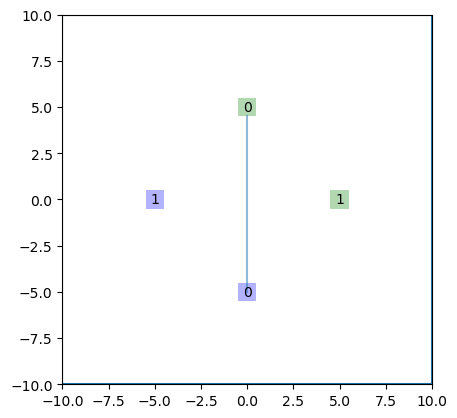

In [75]:

x = start_locs[0]*1.0
goal_loc = goals[0].project(x)


pos = []
for _ in range(200):
    pos.append(np.array(x))
    v_pref = vmax * (goal_loc-x)/np.linalg.norm(goal_loc-x)
    v = safe_v(env,x,v_pref,tau,bloating_r)
    # print(v)
    x += v * tau
    
ax = plt.gca()
draw_env(env,[np.array(pos).T],ax)

# Step 2: avoid other agents that also implement the ORCA protocol.

In [76]:

# def safe_v(env,x,v_pref,tau,bloating_r):
    

v_out = cp.Variable(v_pref.shape)
constraints = []

obstacle_d = [] # Directions of static obstacles
for O in env.obstacles: 
    obstacle_d.append(O.project(x) - x)

for d in obstacle_d:
    l = np.linalg.norm(d)
    constraints.append(d/l @ (v_out*tau) <= (l-bloating_r))

prob = cp.Problem(cp.Minimize(cp.norm(v_pref-v_out)),constraints)
prob.solve()
    # return v_out.value

2.220446049250313e-16

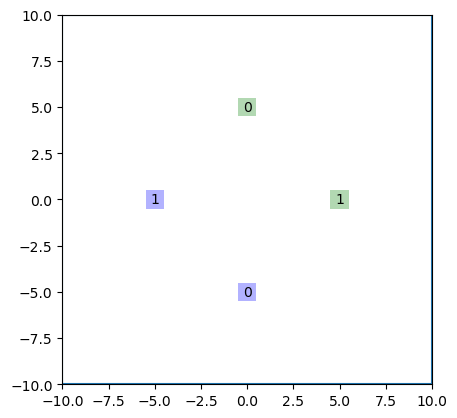

In [77]:

start_locs = np.array([[0,-5],[-5,0]])
goal_locs = np.array([[0,5],[5,0]])


start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

starts = [box_2d_center(s,start_box_side) for s in start_locs]

goals = [box_2d_center(g,goal_box_side) for g in goal_locs]


limits = [(-10.0,10.0),(-10.0,10.0)]

bloating_r = 0.5 


env = NavigationEnv(limits,[],starts,goals)

draw_env(env)

# Velocity obstacle 

In [131]:
def visualize_vo(ax, center, r):

    circ = Circle(center,r,fc = 'green',alpha = 0.2)

    ax.add_artist(circ)

    center_theta = np.arctan2(center[1],center[0])
    phi = np.arcsin(r/np.linalg.norm(center))

    ax.axline([0,0], slope = np.tan(center_theta-phi),ls='dotted')
    ax.axline([0,0], slope = np.tan(center_theta+phi),ls='dotted')

    # ax.arrow(0,0,*(vopt_a-vopt_b),width = 0.01)

    ax.grid(True)
    ax.set_aspect('equal')

def in_vo(center,r, test_pt):
    
    center_theta = np.arctan2(center[1],center[0])
    phi = np.arcsin(r/np.linalg.norm(center))

    in_circ = np.linalg.norm(test_pt - center,axis = 1)<=r

    in_squeeze = np.abs(np.arctan2(test_pt[:,1],test_pt[:,0]) - center_theta) <= phi

    far = np.logical_and(in_squeeze,\
                         np.linalg.norm(test_pt,axis = 1)>= r/np.tan(phi))

    vo = np.logical_or(in_circ,far)
    return vo


In [273]:
np.vstack([xv.flatten(),yv.flatten()]).shape

(2, 100)

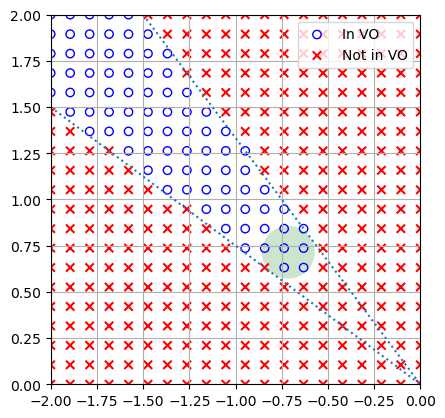

In [276]:
tau = 7
pa, pb = start_locs[0], start_locs[1]
ra = rb = bloating_r
vopt_a, vopt_b = vmax * (goal_locs - start_locs)/np.linalg.norm(goal_locs - start_locs)

plt.figure()
ax = plt.gca()

xlim = (-2,0)
ylim = (0,2)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)


center = (pb-pa)/tau
r = (ra+rb)/tau

center_theta = np.arctan2(center[1],center[0])
phi = np.arcsin(r/np.linalg.norm(center))


visualize_vo(ax,center,r)

N = 5000
nx = 20
ny = 20
xv,yv = np.meshgrid(np.linspace(*xlim,nx),np.linspace(*ylim,ny))
test_pt = np.vstack([xv.flatten(),yv.flatten()]).T

# Check if point is in vo
is_in = in_vo(center,r,test_pt)
ax.scatter(test_pt[is_in,0],test_pt[is_in,1],marker='o',fc='none',ec='blue',label = 'In VO')
ax.scatter(test_pt[np.logical_not(is_in),0],test_pt[np.logical_not(is_in),1],marker='x',fc='none',ec='red',label = 'Not in VO')
plt.legend(loc='upper right')
plt.show()